# Use HawkEars predictions to find clear, focal samples of OSFL calls.

This is done in order to try to preserve the relationship between sound power level in the input audio, and the output score of the model, such that louder and hence closer bird calls produces a higher score and further away calls produce a lower score. 

This is a requirement of downstream statistical applications of the model, such as estimating bird density from the output scores.

The initial dataset contains only a random sample of the first call heard by a human listener within a certain time interval. This provides a range of signal to noise ratios, which is representative of what is expected in the field, however, the first call heard is not always the clearest call. Therefore the HawkEars model was run to find the clearest calls, and these can be mixed into the traininig dataset. 

## Some considerations

- The dataset was split 80/20 into training and testing data. The 20% test data is left untouched, and the remaining 80% has been further split into a validation and training set.

- The dataset is the set of recordings which at some point had an olive sided flycatcher call detected by a human listener. This means that sounds from other habitats are not present in the dataset. The effects of this should be tested by adding sounds from ohter habitats to the training set.

- It is the training set which needs augmenting with the clearest calls.

- The clearest calls are found by taking the top 1% of the scores from the HawkEars model. This is a somewhat arbitrary choice, but it is a good starting point.


## The process
To get the hawkears predictions, the following steps were taken:
1. Output the URLS of all the recordings in the training set to a file
2. open up a google colab instance and download all the recordings in the training set
3. run the HawkEars model on the recordings and save the predictions in a folder.
4. Finally this folder was moved into the data/processed folder of this repo. 

- The hawkears model was in its 'out of the box' state on 7th Feb 2024. Threshold is 0.7 
- To get the recordings into separate 3s windows, the bash command used to run hawkears needed the flag `-m 0 `
- The version of HawkEars which I tried on 13th February didn't run, so I used the version from 7th Feb by running the following command in terminal:

```!git checkout 31b5dfe8a3c2e01d044298b45ea63ee08ef09960 ```

This reverted the code to the version from 7th Feb.

- The recordings took about 3 hours to download, then about 74m to run on google colab on a paid instance v100 GPU and cost 5.36 "compute units" per hour. 
- A second run was done on a more powerful V100 GPU which cost 12 compute units per hour. This was less cost effective because the bulk of the time was spent downloading the recordings, and the inference only changed to 50 minutes. 

In [1]:
# imports
import glob
from pathlib import Path
import pandas as pd
from pandas.errors import EmptyDataError

# for utils
from pathlib import Path
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, keep_cols
import src.utils as utils
import sklearn
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve

import matplotlib.pyplot as plt
import torch

import opensoundscape
import librosa

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_path = Path.cwd().parent.parent / 'data'

# Look at the dataset which will be used to generate the focal recordings
- it consists of the 80% of the full dataset, with a further 20% removed for use as a validation set during training.

In [3]:
train_split = pd.read_pickle(data_path / "processed" / "train_set" / 'train_split.pkl')
train_split.head()

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,media_url,individual_order,location_id,is_valid
recording_id,,,,,,,,,,,,
4396,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,355,False
4427,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,359,False
4429,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,359,False
4446,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,362,False
4452,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[11.31, 169.2]","[0.96, 1.18]",57.482905,-111.378761,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,362,False


The training set contains 2371 unique recordings. 

In [4]:
len(train_split.index.values)

2371

Make sure that the training set split corresponds to the downloaded recordings I have on disk.

In [5]:
recordings_on_disk = glob.glob(str(data_path / "raw" / "recordings" / "OSFL") + "/*.*")
recording_ids = [file.split("/")[-1].split(".")[0].split("-")[1] for file in recordings_on_disk]
len(recording_ids), len(train_split) / len(recording_ids), len(train_split)

(2897, 0.8184328615809459, 2371)

In [6]:
## Takes 12m to run
# durations = {}
# for file in recordings_on_disk:
#     durations[file] = opensoundscape.Audio.from_file(file).duration
# plt.hist(durations.values(), bins=600)
# plt.show()
## Some of the recordings have 0 samples duration

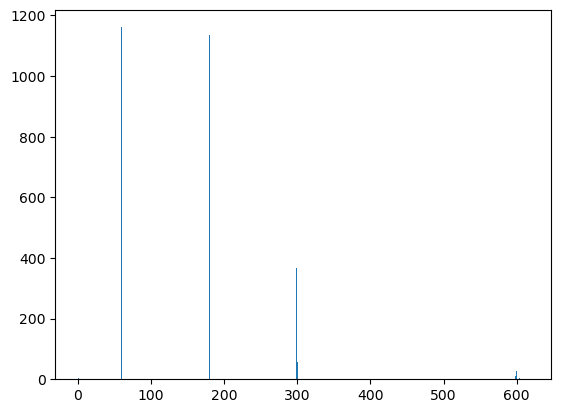

There are 2897 recordings downloaded, but only 2371 of these are in the training set after the validation split. 

Filter the recordings on disk to only include the ones in the training set.

In [7]:
def get_recording_id(file):
    return int(file.split("/")[-1].split(".")[0].split("-")[1])

train_recs = [file for file in recordings_on_disk if get_recording_id(file) in train_split.index.values]

len(train_recs)

2308

After filtering the reocrdings on disk to include only the ones in the training set, there are only 2308 recordings instead of the expected 2371. It is not clear why this is the case. 

# We want to augment the training set with high quality recordings. 
HawkEars was run on the training set and any scores over 0.7 were saved. The following section filters these detections for the top few percent of highest score OSFL detections. 

In [8]:
hawkears_output_files = glob.glob(str(data_path/'processed'/'hawkears_predictions/*.txt'))
len(hawkears_output_files)

2371

In [9]:
def get_recording_id(hawkears_out):
    return int(hawkears_out.split("/")[-1].split(".")[0].split("_")[0])


In [10]:
dfs = []
for file in hawkears_output_files:
    print(f"processing {file}")
    recording_id = get_recording_id(file)
    try:
        df = pd.read_csv(file, sep="\t", header=None)
        df.columns = ["start", "end", "label;score"]
        df["recording_id"] = recording_id
    except EmptyDataError:
        print("(file was empty)")
        continue
    dfs.append(df)

processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/292337_HawkEars.txt
processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/293662_HawkEars.txt
processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/555135_HawkEars.txt
processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/556684_HawkEars.txt
processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/815670_HawkEars.txt
processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/556082_HawkEars.txt
processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/294585_HawkEars.txt
processing /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/291905_HawkEars.txt
processing /Users/mikeg/

### Add the full file path to the recordings df since this is used by opensoundscape for finding files

In [11]:
recordings_df = pd.DataFrame(recordings_on_disk, columns=["full_path"])
recordings_df['file_id'] = recordings_df['full_path'].apply(lambda x: int(x.split("/")[-1].split(".")[0].split("-")[1]))
recordings_df['file_extension'] = recordings_df['full_path'].apply(lambda x: x.split("/")[-1].split(".")[1])


Drop the recordings which are not in the training set, since this is a potential source of data leakage from validation into training set. 

In [12]:
# drop the recordings_df rows which are not in the train_split 
recordings_df = recordings_df[recordings_df['file_id'].isin(train_split.index.values)]
# make a dictionary from file id to file extension
file_id_to_ext_dict = recordings_df.set_index('file_id')['file_extension'].to_dict()


# Make a new dataframe from the hawkears output
- contains the relative path to each recording file
- contains the start, end and species tag for each detection
- therefore we can easily convert these into an opensoundscape AudioFileDataset. 

In [13]:
result_df = pd.concat(dfs, ignore_index=True)
result_df[['label', 'score']] = result_df['label;score'].str.split(';', expand=True)
del(result_df['label;score'])

result_df['file_extension'] = result_df['recording_id'].map(lambda x: file_id_to_ext_dict.get(x, 'Missing'))

result_df.drop(result_df[result_df['file_extension'] == 'Missing'].index, inplace=True)


In [14]:
# concat and parse the hawkears output files
result_df = pd.concat(dfs, ignore_index=True)
result_df[['label', 'score']] = result_df['label;score'].str.split(';', expand=True)
del(result_df['label;score'])

# explicitly drop entries which were not in both the train split and the downloaded recordings.
result_df.drop(result_df[~result_df['recording_id'].isin(file_id_to_ext_dict.keys())].index, inplace=True)
result_df['file_extension'] = result_df['recording_id'].map(lambda x: file_id_to_ext_dict[x])
len(result_df)


199275

In [195]:
start_of_path = "../../data/raw/recordings/OSFL/recording-"
result_df['full_path'] = start_of_path + result_df['recording_id'].astype(str) + "." + result_df['file_extension']
# drop all the rows where the label is not "OSFL"
result_df.drop(result_df[result_df['label'] != 'OSFL'].index, inplace=True)
# drop all the rows where the score is less than 0.99
top_osfls = result_df.drop(result_df[result_df['score'].astype(float) < 0.99].index)
top_osfls['duration'] = top_osfls['end'] - top_osfls['start']
top_osfls.head()

,start,end,recording_id,label,score,file_extension,full_path,duration
105,6.0,9.0,555135,OSFL,0.99,flac,../../data/raw/recordings/OSFL/recording-55513...,3.0
106,7.5,10.5,555135,OSFL,0.99,flac,../../data/raw/recordings/OSFL/recording-55513...,3.0
111,15.0,18.0,555135,OSFL,0.99,flac,../../data/raw/recordings/OSFL/recording-55513...,3.0
128,40.5,43.5,555135,OSFL,1.00,flac,../../data/raw/recordings/OSFL/recording-55513...,3.0
129,42.0,45.0,555135,OSFL,1.00,flac,../../data/raw/recordings/OSFL/recording-55513...,3.0


In [196]:
len(top_osfls)

1038

# rename the columns to work with opensoundscape AudioFileDataset

In [197]:
top_osfls.rename(columns={'full_path': 'file', 'start': 'start_time', 'end': 'end_time'}, inplace=True)

In [198]:
top_osfls.set_index(['file', 'start_time', 'end_time'], inplace=True)


In [199]:
top_osfls.sample(20)

recording_id  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-294742... 21.0       24.0            294742   
../../data/raw/recordings/OSFL/recording-553538... 0.0        3.0             553538   
../../data/raw/recordings/OSFL/recording-538292... 151.5      154.5           538292   
                                                   48.0       51.0            538292   
../../data/raw/recordings/OSFL/recording-255457... 166.5      169.5           255457   
../../data/raw/recordings/OSFL/recording-566242... 157.5      160.5           566242   
../../data/raw/recordings/OSFL/recording-816829... 61.5       64.5            816829   
../../data/raw/recordings/OSFL/recording-255457... 385.5      388.5           255457   
../../data/raw/recordings/OSFL/recording-291502... 15.0       18.0            291502   
../../data/raw/recordings/OSFL/recording-255624... 228.0      231.0           255624   
../../data/raw/recordings/OSFL/recording-255625... 489.0      492.0           255625   
../../data/raw/recordings/OSFL/recording-291904... 97.5       100.5           291904   
../../data/raw/recordings/OSFL/recording-622464... 39.0       42.0            622464   
../../data/raw/recordings/OSFL/recording-293777... 45.0       48.0            293777   
../../data/raw/recordings/OSFL/recording-577623... 288.0      291.0           577623   
../../data/raw/recordings/OSFL/recording-255624... 310.5      313.5           255624   
../../data/raw/recordings/OSFL/recording-538292... 172.5      175.5           538292   
                                                   30.0       33.0            538292   
../../data/raw/recordings/OSFL/recording-255624... 204.0      207.0           255624   
../../data/raw/recordings/OSFL/recording-255457... 58.5       61.5            255457   

                                                                       label  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-294742... 21.0       24.0      OSFL   
../../data/raw/recordings/OSFL/recording-553538... 0.0        3.0       OSFL   
../../data/raw/recordings/OSFL/recording-538292... 151.5      154.5     OSFL   
                                                   48.0       51.0      OSFL   
../../data/raw/recordings/OSFL/recording-255457... 166.5      169.5     OSFL   
../../data/raw/recordings/OSFL/recording-566242... 157.5      160.5     OSFL   
../../data/raw/recordings/OSFL/recording-816829... 61.5       64.5      OSFL   
../../data/raw/recordings/OSFL/recording-255457... 385.5      388.5     OSFL   
../../data/raw/recordings/OSFL/recording-291502... 15.0       18.0      OSFL   
../../data/raw/recordings/OSFL/recording-255624... 228.0      231.0     OSFL   
../../data/raw/recordings/OSFL/recording-255625... 489.0      492.0     OSFL   
../../data/raw/recordings/OSFL/recording-291904... 97.5       100.5     OSFL   
../../data/raw/recordings/OSFL/recording-622464... 39.0       42.0      OSFL   
../../data/raw/recordings/OSFL/recording-293777... 45.0       48.0      OSFL   
../../data/raw/recordings/OSFL/recording-577623... 288.0      291.0     OSFL   
../../data/raw/recordings/OSFL/recording-255624... 310.5      313.5     OSFL   
../../data/raw/recordings/OSFL/recording-538292... 172.5      175.5     OSFL   
                                                   30.0       33.0      OSFL   
../../data/raw/recordings/OSFL/recording-255624... 204.0      207.0     OSFL   
../../data/raw/recordings/OSFL/recording-255457... 58.5       61.5      OSFL   

                                                                       score  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-294742... 21.0       24.0      0.99   
../../data/raw/recordings/OSFL/recording-553538... 0.0        3.0       0.99   
../../data/raw/recordings/OSFL/recording-538292... 151

One of the options on HawkEars is to output neighbouring windows as one long window. This was fixed by passing in the flag `-m 0` to the bash command, and now the detections are all 3s windows.

In [200]:
from opensoundscape import AudioFileDataset, preprocessors, Audio, Spectrogram
from opensoundscape.spectrogram import MelSpectrogram
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid

In [201]:
pre = preprocessors.SpectrogramPreprocessor(3.0)
ds = AudioFileDataset(top_osfls, pre, bypass_augmentations=True)

# Take a look 25 samples of the top hawkears detections

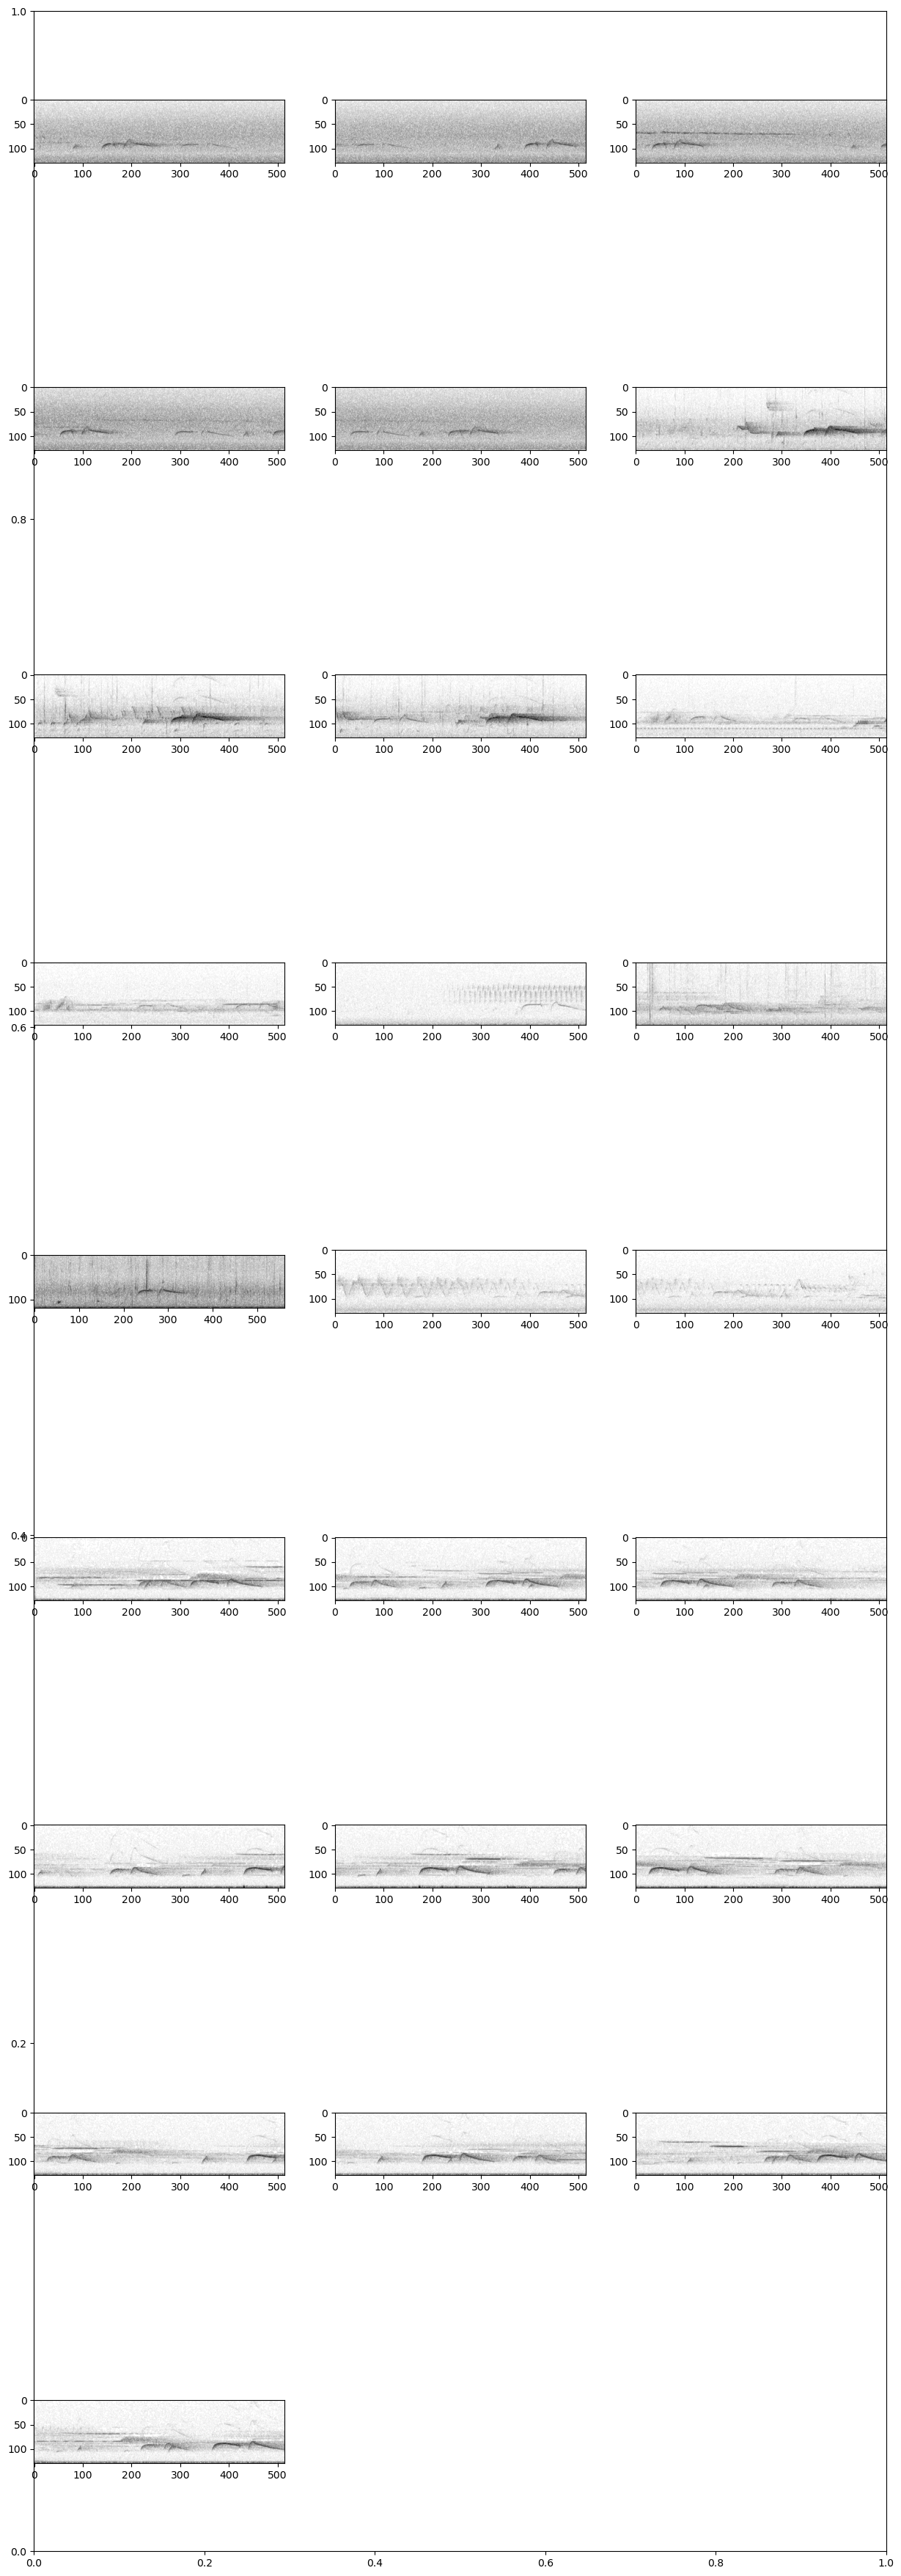

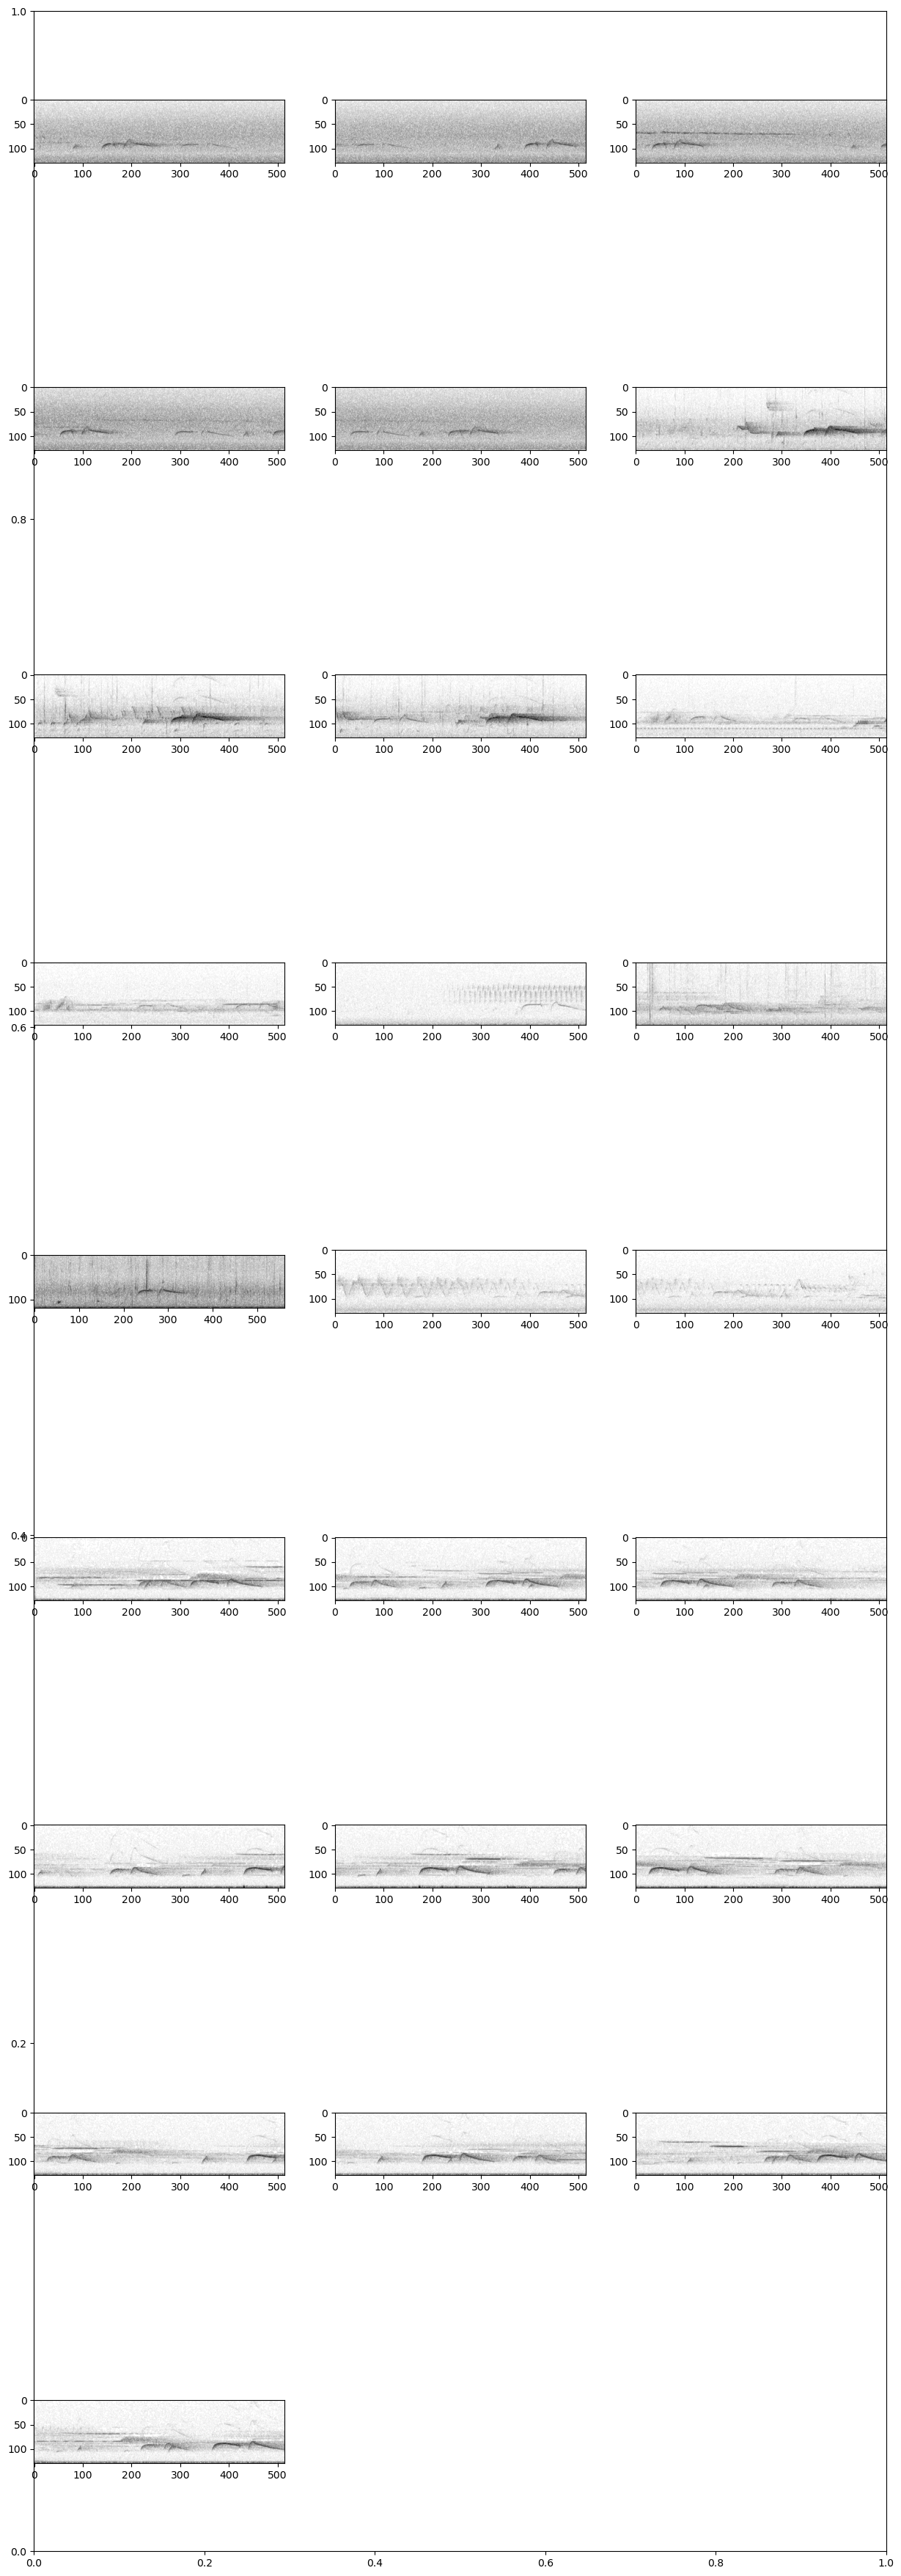

In [221]:
show_tensor_grid([ds[i].data for i in range(25)], columns=3)

# Cycle through the dataset and listen to the audio

In [224]:
idx = 0

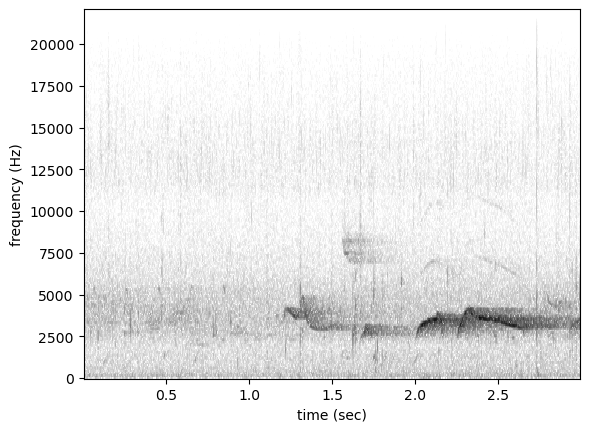

<Audio(samples=(132300,), sample_rate=44100)>

In [230]:
clip = Audio.from_file(top_osfls.index[idx][0], offset=top_osfls.index[idx][1], duration=top_osfls.index[idx][2] - top_osfls.index[idx][1])
Spectrogram.from_audio(clip).plot()
idx+=1
clip
# input("enter a number") # This demonstrates a way of quickly reviewing and scoring the clips. 

So far I have two sources of OSFL calls:
1. The human labelled tags from WildTrax
2. The predictions from the hawkears model. 

These will need to be listened to in order to find the focal calls. 

In addition to these sources, there is the possibility of using Xeno Canto recordings to get more focal predictions, or using another model which is only trained on songs, in order to get only song detections. 


# Further work to do in this notebook
- Create a process to quickly listen and look at a sample and give it either a label confirming osfl song presence, or a score of clarity. These scores can update a column in the AudioFileDataset in real time as the user listens to the samples. 


Recently I listened to 388 3 second clips, which took about 2 hours. It isn't beyond the realms of possibility to listen to all the clips in the human labelled dataset in a reasonable amount of time.



- Take a closer look at the top 1% of hawkears predictions once they have been split into 3s windows.
- Find out how many of these are in the human labelled dataset - there will be some crossover. Since the dataset is split by location, data leakage isn't so much of a concern here - but duplicated samples would be redundant. 